# Imports

In [34]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from numpy import mean, std
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import export_graphviz
from scipy.stats import chi2_contingency, sem, randint
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold,cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, auc, mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import label_binarize, scale
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Bereinigte Daten einholen

In [35]:
# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('neue_datenbank_numeric.db')

# SQL-Abfrage ausführen und Ergebnis in ein Pandas-Dataframe laden
df = pd.read_sql("SELECT * FROM neue_tabelle_mit_allen_numerischen_Daten", conn)

# Verbindung schließen
conn.close()

df_dropped = df

# Korrelation 

In [36]:
# Korrelaitonsmatrix erstellt und in corr_matrix gespeichert => enthält Korrleationskoeffizienten zwischen allen möglichen Paaren
df_dropped_corr = df_dropped.drop('season', axis=1)
corr_matrix = df_dropped_corr.corr()

# stack() wandelt Matrix in Series um, bei der jedes Element ein Paar von Spaltennamen und der Korrelationskoeffizient zwischen diesen Spalten ist
# [abs(corr_matrix) > 0.9] reduziert die Werte auf nur Werte mit einem Wert über 0.9
high_corr_pairs = corr_matrix.stack()[abs(corr_matrix.stack()) > 0.9]

# Indizes der Serie werden zu Spaltennamen des Dataframe 
high_corr_pairs = high_corr_pairs.reset_index()

# Spaltennamen des DataFrames umbenannt für bessere Lesbarkeit
high_corr_pairs.columns = ['Column 1', 'Column 2', 'Correlation']

print(high_corr_pairs)

                          Column 1                        Column 2  \
0                               id                              id   
1                               id                      country_id   
2                               id                       league_id   
3                       country_id                              id   
4                       country_id                      country_id   
5                       country_id                       league_id   
6                        league_id                              id   
7                        league_id                      country_id   
8                        league_id                       league_id   
9                            stage                           stage   
10                    match_api_id                    match_api_id   
11                home_team_api_id                home_team_api_id   
12                away_team_api_id                away_team_api_id   
13                  

In [ ]:
# Maske für oberes Dreieck erstellen
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Erstellen von Heatmap mit Threshold
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix[(corr_matrix >= 0.3) | (corr_matrix <= -0.3)],
            cmap='coolwarm', annot=True, fmt='.2f', mask=mask)

# Anpassen der Ausgabe
sns.set(font_scale=1.2)
sns.set_style({'font.family': 'serif', 'fontcolor': 'black'})
plt.xticks(rotation=45, ha='right')

plt.show()


# Chi Squared

In [ ]:
 # erstelle ein Dataframe für die Ergebnis von Chi2
chi2_results_df = pd.DataFrame(columns=['Column 1', 'Column 2', 'Chi-Squared', 'P-Value'])

# iteriert über jede Spalte des Dataframes
for col in df_dropped.columns:
    comparison_col = col

    # iteriert über jede Spalte des Dataframes
    for col in df_dropped.columns:

        # überspringt den Schritt, wenn die Spalten die gleichen sind
        if col == comparison_col:
            continue

        # erstellt eine Kontingenztabelle
        contingency_table = pd.crosstab(df_dropped[comparison_col], df_dropped[col])

        # führt chi2 aus und printed das Ergebnis
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
                    #print(f\Chi-squared test for columns '{comparison_col}' and '{col}': chi2={chi2}, pval={pval}\)
        new_row = {'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}
        chi2_results_df = pd.concat([chi2_results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

    print(chi2_results_df)

In [ ]:
# Pivotiere chi2_results_df, um eine Matrix zu erstellen
heatmap_data = chi2_results_df.pivot(index='Column 1', columns='Column 2', values='P-Value')

# Größe der Ausgabe
plt.figure(figsize=(30, 30))

# Erzeugen einer Heatmap
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.2f')

# Anpassen der Ausgabe
sns.set(font_scale=1.2)
sns.set_style({'font.family': 'serif', 'fontcolor': 'black'})
plt.xticks(rotation=45, ha='right')
plt.show()


# Spalten mit hoher Korrelation löschen

In [37]:
df_dropped = df_dropped.drop('id', axis=1)
df_dropped = df_dropped.drop('country_id', axis=1)
df_dropped = df_dropped.drop('league_id', axis=1)
df_dropped = df_dropped.drop('season', axis=1)
df_dropped = df_dropped.drop('home_team_goal', axis=1)
#df_dropped = df_dropped.drop('away_team_goal', axis=1)

# Weitere Berechnungen und Beziehungen

## Ist eine Auswirkung von Heimspiel oder Auswärtsspiel zu erkennen?

In [ ]:
# Zähle die Anzahl der Vorkommnisse von -1, 0 und 1 in der Spalte 'label_outcome'
count = df_dropped['label_outcome'].value_counts()

# Berechne den Prozentsatz, den jeder Wert auf das gesamte Dataframe bezieht
percent = df_dropped['label_outcome'].value_counts(normalize=True) * 100

# Gib die Ergebnisse aus
print(count)
print(percent)

## Wie wirkt sich die Anzahl der Rechtsfüßler in einem Team auf den Ausgang des Spiels aus?

In [ ]:
# Erzeugen eines Streudiagramms mit der Anzahl der rechtsfüßigen Spieler und dem Ausgang des Spiels
plt.scatter(df_dropped['right_foot_percentage_hometeam'], df_dropped['label_outcome'])
plt.xlabel('Anzahl der rechtsfüßigen Spieler')
plt.ylabel('Ausgang des Spiels')

# Hinzufügen der Linie
x = df_dropped['right_foot_percentage_hometeam']
y = df_dropped['label_outcome']
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope*x + intercept, color='red')

# Ausgabe des Diagramms
plt.show()

# Erstelle ein Heatmap-Diagramm mit der Anzahl der rechtsfüßigen Spieler und dem Ausgang des Spiels
sns.heatmap(pd.crosstab(df_dropped['right_foot_percentage_hometeam'], df['label_outcome'], normalize='index'), cmap='coolwarm')
plt.xlabel('Ausgang des Spiels')
plt.ylabel('Anzahl der rechtsfüßigen Spieler')
plt.show()



# Wie wirkt sich das Rating des Heimteams auf die Anzahl der Tore der Auswärtsmannschaft aus? #

Auswirkungen des average_rating_hometeam auf die Anzahl an Gegentoren:


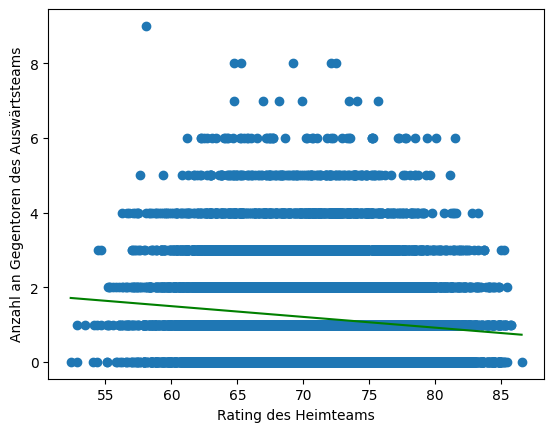

In [38]:
# Auswirkung von home_team_rating auf away_team_goal
x = df_dropped['average_rating_hometeam']
y = df_dropped['away_team_goal']

df_dropped = df_dropped.drop('away_team_goal', axis=1)

plt.scatter(x, y)  
plt.plot(np.unique(x),np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'green')  
print("Auswirkungen des average_rating_hometeam auf die Anzahl an Gegentoren:")
plt.xlabel("Rating des Heimteams")
plt.ylabel("Anzahl an Gegentoren des Auswärtsteams")
plt.show()

# Wie wirkt sich das Rating des Heimteams auf den Spielausgang aus? #

In [ ]:
# Auswirkung von home_team_rating auf label_outcome
x = df_dropped['average_rating_hometeam']
y = df_dropped['label_outcome']

plt.scatter(x, y)  
plt.plot(np.unique(x),np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'green')  
print("Auswirkungen des average_rating_hometeam auf den Spielausgang (Aus Sicht des Heimteams):")
plt.xlabel("Rating des Heimteams")
plt.ylabel("Spielausgang")
plt.show()

# Wie wirkt sich das Rating des Auswärtsteams auf den Spielausgang aus? #

In [ ]:
# Auswirkung von away_team_rating auf label_outcome
x = df_dropped['average_rating_awayteam']
y = df_dropped['label_outcome']

plt.scatter(x, y)  
plt.plot(np.unique(x),np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'green')  
print("Auswirkungen des average_rating_awayteam auf den Spielausgang (Aus Sicht des Heimteams):")
plt.xlabel("Rating des Auswärtsteams")
plt.ylabel("Spielausgang")
plt.show()

# Lineare Regression

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Ermittlung dieser Werte geschah durch ausprobieren von allen n_features_to_select von 1-15 und gleichzeitiger Variation von test_size von 0.1-0.6
n_features_to_select = 5
test_size = 0.1

# Trennung von Features und Zielvariablen
features = df_dropped.drop('label_outcome', axis=1)
target = df_dropped['label_outcome']

# Definition des Modells
model = LinearRegression()

# Erstellung des RFE-Objekts mit der gewünschten Anzahl an Features
rfe = RFE(model, n_features_to_select=n_features_to_select)

# Anpassung des RFE-Objekts an die Daten
rfe.fit(features, target)

# Ausgabe der ausgewählten Features
selected_features = features.columns[rfe.support_]
print(selected_features)

# Trennung von Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features[selected_features], target, test_size=test_size, random_state=42)

# Training des Modells
model.fit(features_train, target_train)

# Vorhersage der Testdaten
y_pred = model.predict(features_test)

# Berechnung des R^2-Wertes
r2 = r2_score(target_test, y_pred)
print("R-squared value: {:.2f}".format(r2))

# Berechnung des Mean Squared Error
mse = mean_squared_error(target_test, y_pred)
print('MSE: {:.2f}'.format(mse))

# Berechnung des Mean Absolute Error
mae = mean_absolute_error(target_test, y_pred)
print('MAE: {:.2f}'.format(mae))

# Berechnung der Residuen
residuals = target_test - y_pred

# Erstellung des Residuenplots
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show() # Daten sollte zufällig um Null herum sein

# Erstellung des Verteilungsplots
sns.histplot(target_test, kde=True, color='b', label='Actual Values')
sns.histplot(y_pred, kde=True, color='r', label='Predicted Values')
plt.legend()
plt.show()

# Erstellung des Scatterplots
plt.scatter(target_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Feature Importance berechnen durch Permutationsimportanz
result = permutation_importance(model, features_test, target_test, n_repeats=10, random_state=42)
importance = result.importances_mean
plt.barh(selected_features, importance)
plt.subplots_adjust(left=.3)
plt.title("Feature Importance")
plt.show()

# Feature Coefficients berechnen
coefs = model.coef_
plt.barh(selected_features, coefs)
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.title("Feature Coefficients")
plt.show()

In [ ]:
# Zusammenführen der ausgewählten Features und des Zielvariablenvektors in ein Pandas DataFrame
data = pd.concat([features[selected_features], target], axis=1)

# Erstellung eines Paarplots, um die Beziehungen zwischen den Variablen zu visualisieren
# x_vars: Ausgewählte Features, y_vars: Zielvariable
sns.pairplot(data, x_vars=selected_features, y_vars='label_outcome', height=5, aspect=1, kind='reg')


In [ ]:
# Modell trainieren
model.fit(features[selected_features], target)

# Vorhersagen treffen
y_pred = model.predict(features[selected_features])

# Regressionsplot erstellen
sns.regplot(x=target, y=y_pred, ci=None)

# Achsenbeschriftungen und Titel setzen
plt.xlabel('Actual Outcome')
plt.ylabel('Predicted Outcome')
plt.title('Linear Regression Model')

# Plot anzeigen
plt.show()

# Random Forest

Zunächst Beschneiden der Daten, Test mit 0,5er Split und Berechnung der besten Hyperparameter mit diesem Split.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Entfernen von Zeilen, die NaN-Werte in der Zielvariablen enthalten
df_dropped_rf = df.dropna(subset=['label_outcome'])

# Trennung von Features und Zielvariablen, Aussortieren von Features
features = df_dropped_rf.drop(['match_api_id', 'date', 'season', 'id', 'country_id', 'league_id', 'home_team_api_id', 'away_team_api_id', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7','home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7','away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'label_outcome', 'home_team_goal', 'away_team_goal'], axis=1)
target = df_dropped_rf['label_outcome']

# Aufteilen der Daten in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.5, random_state=42)

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training des Modells auf den Trainingsdaten
rf.fit(features_train, target_train)

# Vorhersage auf den Testdaten
target_pred = rf.predict(features_test)

# Berechnung der Genauigkeit
accuracy = accuracy_score(target_test, target_pred)
print(f"Test-Size 0.5, Genauigkeit: {accuracy}")

estimator = rf.estimators_[0]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Zu png umwandeln
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'], shell=True)

# Als Output ausgeben
from IPython.display import Image
tree = Image(filename = 'tree.png')
display(tree)

#### Finde die besten Hyperparameter

# Definition der Hyperparameter und ihrer möglichen Werte
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20),
              'min_samples_split': randint(2,10),
              'min_samples_leaf': randint(1,10)}

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(random_state=42)

# Initialisierung des Randomized Search CV Objekts
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist,
                                 n_iter=10,
                                 cv=5,
                                 random_state=42)

# Suche nach den besten Hyperparametern auf den Trainingsdaten
rand_search.fit(features_train, target_train)

# Ausgabe der besten Hyperparameter und der Genauigkeit auf den Testdaten
print(f"Beste Hyperparameter: {rand_search.best_params_}")
print(f"Genauigkeit auf Testdaten: {rand_search.score(features_test, target_test)}")

Nach einigem ausprobieren hat der 0,1er Split knapp die besten Ergebnisse geliefert. Im folgenden Codeblock wird daher dieser Split verwendet. Zunächst werden 100 Bäume berechnet, dann 300.

In [ ]:
# Aufteilen der Daten in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=42)

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training des Modells auf den Trainingsdaten
rf.fit(features_train, target_train)

# Vorhersage auf den Testdaten
target_pred = rf.predict(features_test)

# Berechnung der Genauigkeit
accuracy = accuracy_score(target_test, target_pred)
print(f"Test-Size 0.1, Genauigkeit: {accuracy}")

estimator = rf.estimators_[0]

export_graphviz(estimator, out_file='tree01.dot', 
                feature_names = features_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Zu png umwandeln
from subprocess import call
call(['dot', '-Tpng', 'tree01.dot', '-o', 'tree01.png', '-Gdpi=600'], shell=True)

# Als Output anzeigen
from IPython.display import Image
tree = Image(filename = 'tree01.png')
display(tree)

########################################################################################################

# Aufteilen der Daten in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=42)

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(n_estimators=300, random_state=42 ,max_depth=5)

# Training des Modells auf den Trainingsdaten
rf.fit(features_train, target_train)

# Vorhersage auf den Testdaten
target_pred = rf.predict(features_test)

# Berechnung der Genauigkeit
accuracy = accuracy_score(target_test, target_pred)
print(f"Test-Size 0.1, Genauigkeit: {accuracy}")

estimator = rf.estimators_[0]

export_graphviz(estimator, out_file='tree02.dot', 
                feature_names = features_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Zu png umwandeln
from subprocess import call
call(['dot', '-Tpng', 'tree02.dot', '-o', 'tree02.png', '-Gdpi=600'], shell=True)

# Als Output anzeigen
from IPython.display import Image
tree = Image(filename = 'tree02.png')
display(tree)

Jetzt werden die besten Hyperparameter für den 0,1er Split berechnet.

In [ ]:
# Definition der Hyperparameter und ihrer möglichen Werte
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20),
              'min_samples_split': randint(2,10),
              'min_samples_leaf': randint(1,10)}

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(random_state=42)

# Initialisierung des Randomized Search CV Objekts
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist,
                                 n_iter=10,
                                 cv=5,
                                 random_state=42)

# Suche nach den besten Hyperparametern auf den Trainingsdaten
rand_search.fit(features_train, target_train)

# Ausgabe der besten Hyperparameter und der Genauigkeit auf den Testdaten
print(f"Beste Hyperparameter: {rand_search.best_params_}")
print(f"Genauigkeit auf Testdaten: {rand_search.score(features_test, target_test)}")

### Visualisierung mit optimierten Einstellungen

In [ ]:
# Beschaffen des besten Entscheidungsbaums und dessen Index
best_rf = rand_search.best_estimator_
best_index = rand_search.best_index_

# Visualisierung des besten Entscheidungsbaums
estimator = best_rf.estimators_[best_index]

export_graphviz(estimator, out_file='treebest.dot', 
                feature_names = features_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Zu png umwandeln
from subprocess import call
call(['dot', '-Tpng', 'treebest.dot', '-o', 'treebest.png', '-Gdpi=600'], shell=True)

# Als Output anzeigen
from IPython.display import Image
tree = Image(filename = 'treebest.png')
display(tree)

### Kennzahlen bei optimierten Einstellunngen

In [ ]:
# Vorhersage auf den Testdaten mit den besten Hyperparametern
best_rf = rand_search.best_estimator_
target_pred = best_rf.predict(features_test)

# Berechnung des F1-Scores
f1 = f1_score(target_test, target_pred, average='weighted')
print(f"F1-Score: {f1}")

# Berechnung der AUC
target_proba = best_rf.predict_proba(features_test)
auc_score = roc_auc_score(target_test, target_proba, multi_class='ovr')
print(f"AUC: {auc_score}")

# Berechnung der Precision
precision = precision_score(target_test, target_pred, average='weighted', zero_division=1)
print(f"Precision: {precision}")

# Berechnung des Recall
recall = recall_score(target_test, target_pred, average='weighted', zero_division=1)
print(f"Recall: {recall}")

### Feature Importance

In [ ]:
# Fit des Random Forest Modells
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_train, target_train)

# Berechnung der Feature Importance
importance = best_rf.feature_importances_
sorted_idx = importance.argsort()[::-1]
print("Feature importance:")
for i in sorted_idx:
    print(f"{features_train.columns[i]}: {importance[i]}")

# Erstellung der Confusion Matrix
target_pred = rf.predict(features_test)
conf_mat = confusion_matrix(target_test, target_pred)

# Plot der Confusion Matrix
plt.figure(figsize= (7,7))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', 
            xticklabels=["Niederlage", "Unentschieden", "Sieg"], yticklabels=["Niederlage", "Unentschieden", "Sieg"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### ROC Kurven

In [ ]:
# Binarisieren der Zielvariablen
target_bin = label_binarize(target_test, classes=rand_search.classes_)
n_classes = target_bin.shape[1]

# Wahrscheinlichkeiten für Klassen berechnen
target_proba = best_rf.predict_proba(features_test)

# ROC Kurve und Fläche unter der Kurve berechnen
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_bin[:, i], target_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(target_bin.ravel(), target_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC Kurven für alle Klassen plotten
plt.figure()
lw = 2
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], ['Win', 'Draw', 'Lose'][i]))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Visuelle Anpassungen
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Logistische Regression

In [39]:
# Trennung in ein Dataframe mit den Features und eines für die Zielvariable
features_all = df_dropped.drop('label_outcome', axis=1)
target_all = df_dropped['label_outcome']

In [40]:
# Herausnehmen der nicht sinnvollen Werte
features_all = features_all.drop(['stage', 'match_api_id', 'date', 'home_team_api_id', 'away_team_api_id', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7','home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7','away_player_8', 'away_player_9', 'away_player_10', 'away_player_11'], axis=1)

# Errechnen des VIF für jedes Feature (Testen auf Multikollinarität -> liegt vor wenn VIF > 10)
vif_scores = pd.DataFrame() 
vif_scores['Attribute'] = features_all.columns 

vif_scores['VIF Scores'] = [variance_inflation_factor(features_all.values, i) for i in range(len(features_all.columns))] 
display(vif_scores)

,Attribute,VIF Scores
0,B365H,14.265857
1,B365D,120.692853
2,B365A,33.599613
3,average_rating_hometeam,687.939675
4,average_rating_awayteam,659.139051
5,average_height_hometeam,11516.493364
6,average_height_awayteam,11622.324496
7,average_weight_hometeam,2323.768358
8,average_weight_awayteam,2350.710464
9,average_age_hometeam,298.167808


In [41]:
# Herausnehmen der Größe, da der hohe VIF-Wert eine Abhängigkeit beschreibt -> Gewicht und Größe sind bei Sportlern meist voneinander abhängig
features_all = features_all.drop(["average_height_hometeam", "average_height_awayteam"], axis=1)

vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = features_all.columns 
vif_scores["VIF Scores"] = [variance_inflation_factor(features_all.values, i) for i in range(len(features_all.columns))] 
display(vif_scores)

,Attribute,VIF Scores
0,B365H,14.167595
1,B365D,117.948459
2,B365A,33.090832
3,average_rating_hometeam,687.558930
4,average_rating_awayteam,657.885400
5,average_weight_hometeam,1024.718827
6,average_weight_awayteam,1033.932046
7,average_age_hometeam,284.176573
8,average_age_awayteam,286.172664
9,right_foot_percentage_hometeam,45.000454


# Bestimmen der Genauigkeit der Vorhersagen bei 2-10 Folds mithilfe des RepeatedKFolds # 

In [ ]:
# evaluieren des Modells mit einer bestimmten Anzahl an Wiederholungen
def evaluate_model(X, y, wiederholungen, s):
 # Vorbereiten der cross-validation-Prozedur
 crossvalidation = RepeatedKFold(n_splits=s, n_repeats=wiederholungen, random_state=1)
 # Modell erstellen
 modell = LogisticRegression()
 # Modell evaluieren
 ergebnis = cross_val_score(modell, X, y, scoring='accuracy', cv=crossvalidation, n_jobs=-1)
 return ergebnis

wiederholungen = range(1,6)

splits = range(2,11)
for s in splits:
    for w in wiederholungen:
        scores = evaluate_model(features_all, target_all, w, s)
        print(f"Genauigkeit bei {s} Splits: {mean(scores)}")
    print("---------------------------------------------------")

# Bestimmen der Genauigkeit, Confusions-Matrix, R2-Score und Mean Squared Error (Train-Test-Split-Aufteilung von 10 bis 90%)

In [ ]:
testSize = range(1,10)
for t in testSize:
    X_train, X_test, y_train, y_test = train_test_split(features_all, target_all, test_size=(t/10), random_state=42)
    mymodel = LogisticRegression(multi_class="multinomial", solver="lbfgs", penalty='l2', max_iter=5000)
    mymodel.fit(X_train, y_train)

    predicted_output = mymodel.predict(X_test)

    cm = confusion_matrix(y_test, predicted_output)
    mse = mean_squared_error(y_test, predicted_output)
    r2 = r2_score(y_test, predicted_output)
    print(f"Genauigkeit [bei einer Testgröße von {t*10}%]: {mymodel.score(X_test, y_test)}")
    print(f"mean squared error: {mse}")
    print(f"r2 score: {r2}")
 
    plt.figure(figsize= (7,7))
    sns.heatmap(cm, yticklabels=["Niederlage", "Unentschieden", "Sieg"], xticklabels=["Niederlage", "Unentschieden", "Sieg"], annot=True, fmt='g')
    plt.xlabel('Vorhergesagter Wert')
    plt.ylabel('tatsächlicher Wert')
    plt.show()
    print("-------------------------------------------------------------------------------")

# Genauere Betrachtung der logistischen Regression mit 10% Trainingsgröße und 90% Testgröße

Klassen-Verteilung der Trainingsdaten: 


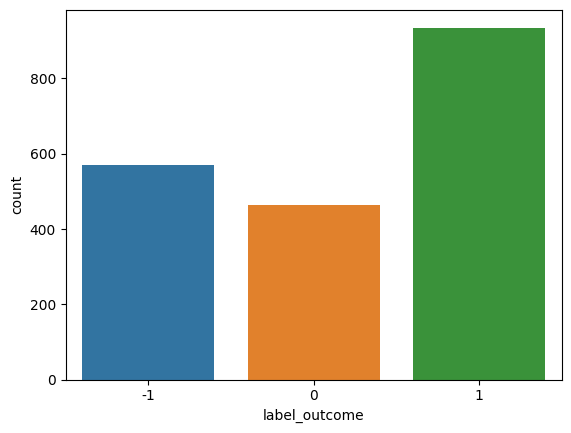

Klassen-Verteilung der Testdaten: 


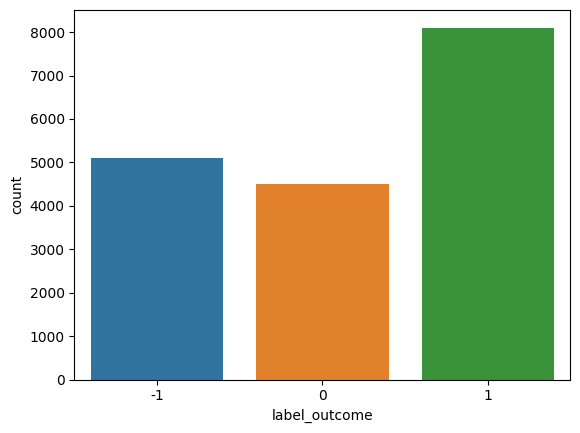

Genauigkeit des Modells: 0.5308091637512696


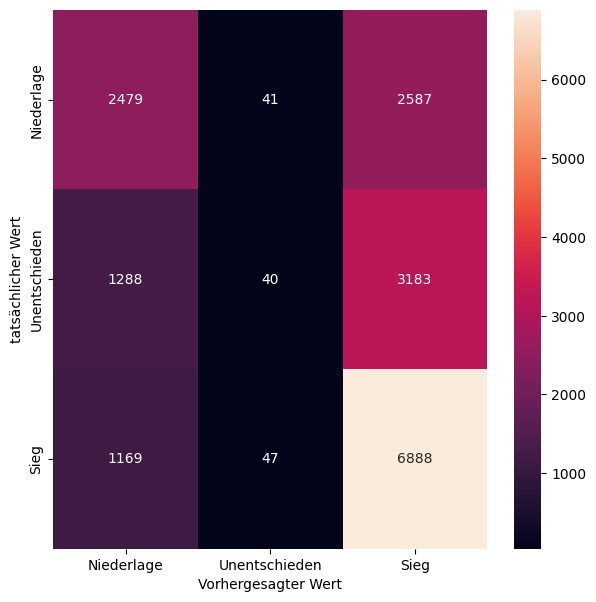

In [42]:
print("Klassen-Verteilung der Trainingsdaten: ")
sns.countplot(x = y_train, data = features_all)
plt.show()
print("Klassen-Verteilung der Testdaten: ")
sns.countplot(x = y_test, data = features_all)
plt.show()


X_train, X_test, y_train, y_test = train_test_split(features_all, target_all, test_size=0.90, random_state=42)
mymodel = LogisticRegression(multi_class="multinomial", solver="lbfgs", penalty='l2', max_iter=5000)
mymodel.fit(X_train, y_train)
predicted_output = mymodel.predict(X_test)
print(f"Genauigkeit des Modells: {mymodel.score(X_test, y_test)}")


cm = confusion_matrix(y_test, predicted_output)
plt.figure(figsize= (7,7))
sns.heatmap(cm, yticklabels=["Niederlage", "Unentschieden", "Sieg"], xticklabels=["Niederlage", "Unentschieden", "Sieg"], annot=True, fmt='g')
plt.xlabel('Vorhergesagter Wert')
plt.ylabel('tatsächlicher Wert')
plt.show()

In [ ]:
# mit der Methode predict_proba kann man gut sehen, wie das Modell die Wahrscheinlichkeiten der Inputwerte für Sieg, Unentschieden und Niederlage berechnet 
# und sich dementsprechend entscheidet für den höchsten Wert entscheidet
print(mymodel.predict_proba(X_test))

In [ ]:
# Anzeige des Classification-Reports, um einen genaueren Überblick über Werte wie Recall und Precision zu erhalten
report = classification_report(y_test, predicted_output)
print(report)

# Live-Demo der Vorhersage eines Ergebnisses (Train-Testsplit von 10%-90%)

In [44]:
# Test eines Spielausgangs mit folgenden Daten:
df_test = pd.DataFrame({"B365H": 1, "B365D": 2, "B365A": 3, "average_rating_hometeam": 80, "average_rating_awayteam": 70, "average_weight_hometeam": 170, "average_weight_awayteam": 180, 
        "average_age_hometeam": 28, "average_age_awayteam": 30, "right_foot_percentage_hometeam": 0.8, "right_foot_percentage_awayteam": 0.5, "last_three_matches_hometeam": 5, 
        "last_three_matches_awayteam": 2}, index=[0])

# Vorhergesagter Ausgang ist [1], also Sieg für das Heimteam
predicted_output = mymodel.predict(df_test)
print(f"Vorhergesagter Ausgang des Spiels: {predicted_output}")
print("Errechnete Wahrscheinlichkeit für den Ausgang des Spiels:")
print("  Niederlage  Unentsch.     Sieg")
print(mymodel.predict_proba(df_test))

Vorhergesagter Ausgang des Spiels: [1]
Errechnete Wahrscheinlichkeit für den Ausgang des Spiels:
  Niederlage  Unentsch.     Sieg
[[0.09624749 0.30980234 0.59395016]]


# logarithmische Koeffizienten

In [ ]:
spalten = X_train.columns
koeffizientenFürNiederlage = pd.Series(mymodel.coef_[0], spalten)
koeffizientenFürUnentschieden = pd.Series(mymodel.coef_[1], spalten)
koeffizientenFürSieg = pd.Series(mymodel.coef_[2], spalten)

print(f"Klasse: {mymodel.classes_}")
print("-----------------------------------------------------")
print("logarithmische Koeffizienten:")
print("-----------------------------------------------------")
print("Koeffizienten für Klasse -1 (Niederlage):")
print(koeffizientenFürNiederlage)
print("-----------------------------------------------------")
print("Koeffizienten für Klasse 0 (Unentschieden):")
print(koeffizientenFürUnentschieden)
print("-----------------------------------------------------")
print("Koeffizienten für Klasse 1 (Sieg):")
print(koeffizientenFürSieg)
print("-----------------------------------------------------")

# zugehörige reguläre Koeffizienten

In [ ]:
# logarithmische zu regulären Werten umrechnen
koeffizientenFürNiederlageRegulaer = pd.Series(np.exp(mymodel.coef_[0]), spalten)
koeffizientenFürUnentschiedenRegulaer = pd.Series(np.exp(mymodel.coef_[1]), spalten)
koeffizientenFürSiegRegulaer = pd.Series(np.exp(mymodel.coef_[2]), spalten)

print("-----------------------------------------------------")
print("reguläre Koeffizienten:")
print("-----------------------------------------------------")
print("Koeffizienten für Klasse -1 (Niederlage):")
print(koeffizientenFürNiederlageRegulaer)
print("-----------------------------------------------------")
print("Koeffizienten für Klasse 0 (Unentschieden):")
print(koeffizientenFürUnentschiedenRegulaer)
print("-----------------------------------------------------")
print("Koeffizienten für Klasse 1 (Sieg):")
print(koeffizientenFürSiegRegulaer)
print("-----------------------------------------------------")

In [ ]:
# logarithmische Wahrscheinlichkeit, um die die Wahrscheinlichkeit steigt bzw. sinkt, eine Niederlage/Unentschieden/Sieg zu erreichen, wenn der Wert des Features um 1 steigt
# diesen Wert kann man bis auf das Vorzeichen nicht sinnvoll interpretieren, weil es eine logit-Funktion statts einer Linearen ist
print(("logarithmische Auswirkung eines Features auf den Spielausgang Niederlage:"))
plt.figure(figsize= (4,4))
koeffizientenFürNiederlage.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("logarithmische Auswirkung")
plt.show()

print(("logarithmische Auswirkung eines Features auf den Spielausgang Unentschieden:"))
plt.figure(figsize= (4,4))
koeffizientenFürUnentschieden.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("logarithmische Auswirkung")
plt.show()

print(("logarithmische Auswirkung eines Features auf den Spielausgang Sieg:"))
plt.figure(figsize= (4,4))
koeffizientenFürSieg.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("logarithmische Auswirkung")
plt.show()

In [ ]:
# reguläre Wahrscheinlichkeit, um die die Wahrscheinlichkeit steigt bzw. sinkt, eine Niederlage/Unentschieden/Sieg zu erreichen, wenn der Wert des Features um 1 steigt
# Um die Koeffizienten interpretieren zu können müssen diese in reguläre Koeffizienten mithilfe von exp() umgewandelt werden
print(("reguläre Auswirkung eines Features auf den Spielausgang Niederlage:"))
plt.figure(figsize= (4,4))
koeffizientenFürNiederlageRegulaer.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("reguläre Auswirkung")
plt.show()

print(("reguläre Auswirkung eines Features auf den Spielausgang Unentschieden:"))
plt.figure(figsize= (4,4))
koeffizientenFürUnentschiedenRegulaer.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("reguläre Auswirkung")
plt.show()

print(("reguläre Auswirkung eines Features auf den Spielausgang Sieg:"))
plt.figure(figsize= (4,4))
koeffizientenFürSiegRegulaer.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("reguläre Auswirkung")
plt.show()

# Betrachtung des Ergebnisses bei einem Testsplit von 99%

In [ ]:
# Versuch, ob bei weniger Trainingsdaten auch Unentschieden besser vorhergesagt werden können
X_train, X_test, y_train, y_test = train_test_split(features_all, target_all, test_size=0.99, random_state=42)
mymodel = LogisticRegression(multi_class="multinomial", solver="lbfgs", penalty='l2', max_iter=5000)
mymodel.fit(X_train, y_train)
predicted_output = mymodel.predict(X_test)

cm = confusion_matrix(y_test, predicted_output)
mse = mean_squared_error(y_test, predicted_output)
r2 = r2_score(y_test, predicted_output)
print(f"Genauigkeit [bei einer Testgröße von 99%]: {mymodel.score(X_test, y_test)}")
print(f"mean squared error: {mse}")
print(f"r2 score: {r2}")

plt.figure(figsize= (7,7))
sns.heatmap(cm, yticklabels=["Niederlage", "Unentschieden", "Sieg"], xticklabels=["Niederlage", "Unentschieden", "Sieg"], annot=True, fmt='g')
plt.xlabel('Vorhergesagter Wert')
plt.ylabel('tatsächlicher Wert')
plt.show()

report = classification_report(y_test, predicted_output)
print(report)